In [1]:
# PDF 文件處理與資料萃取系統
# ## 系統功能說明
# 本系統用於處理大量 PDF 文件，將其轉換為結構化 JSON 資料以供後續分析使用。
#
# ### 主要功能：
# 1. PDF 文件文字萃取
# 2. 判決相關段落識別 
# 3. JSON 格式轉換與儲存
# 4. 增量式處理機制
#
# ### 使用套件
# - pdfminer.six：PDF 文字萃取
# - pandas：資料處理
# - jieba：中文分詞
# - tqdm：進度顯示


In [2]:
!pip install pandas jieba scikit-learn matplotlib

In [3]:
# === 匯入套件 ===
!pip install pdfminer.six tqdm

import re
import json
from pathlib import Path
from tqdm import tqdm
from pdfminer.high_level import extract_text

# === 基本設定 ===
input_dir = Path.cwd()                     # 頂層資料夾
output_json = Path("all_pdfs_parsed.json") # 匯出 JSON 結果
output_json.parent.mkdir(parents=True, exist_ok=True)

# === 正規化檔名：移除流水號與多餘符號 ===
def normalize_filename(name: str) -> str:
    """
    移除開頭流水號或符號，如：
    001_XXX.pdf → XXX.pdf
    01-XXX.pdf → XXX.pdf
    (3)XXX.pdf → XXX.pdf
    """
    name = re.sub(r"^[\s$begin:math:text$$end:math:text$$begin:math:display$$end:math:display$\-_\d]+", "", name)
    return name.strip()

# === 解析 PDF ===
def pdf_to_text(pdf_path: Path) -> str:
    try:
        text = extract_text(pdf_path)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    except Exception as e:
        print(f"⚠️ 無法解析：{pdf_path.name} ({e})")
        return ""

def find_verdicts(text: str) -> list[str]:
    sentences = re.split(r'[。！？\n]', text)
    return [s.strip() for s in sentences if '判決' in s]

# === 載入既有 JSON ===
existing = []
if output_json.exists():
    try:
        existing = json.loads(output_json.read_text(encoding="utf-8"))
        print(f"🔹 已載入既有資料，共 {len(existing)} 筆。")
    except Exception as e:
        print(f"⚠️ 既有 JSON 讀取失敗，將重新建立 ({e})")
        existing = []

# === 建立已處理集合（以正規化檔名為鍵）===
existing_names = {
    normalize_filename(Path(entry["filename"]).name)
    for entry in existing if "filename" in entry
}

# === 主流程 ===
pdf_files = sorted(input_dir.rglob("*.pdf"))
new_results = []
new_filenames = []
skipped = 0

# 排除非正式文獻的檔案（如系統圖示或工具檔）
IGNORE_KEYWORDS = {"matplotlib", "qt4_editor_options", "subplots",
                   "back", "forward", "home", "zoom_to_rect", "filesave", "hand", "help"}


for pdf in tqdm(pdf_files, desc="Parsing PDFs"):
    norm_name = normalize_filename(pdf.name)

    # 系統垃圾檔案過濾
    if any(key in norm_name.lower() for key in IGNORE_KEYWORDS):
        print(f"🚫 系統或範例檔案跳過：{pdf.name}")
        continue

    if norm_name in existing_names:
        print(f"⏩ 已存在（同名或流水號版本）：{pdf.name}")
        skipped += 1
        continue

    text = pdf_to_text(pdf)
    if not text:
        print(f"⚠️ 空白或無法解析：{pdf.name}")
        continue

    verdicts = find_verdicts(text)
    entry = {
        "path": str(pdf.resolve()),
        "filename": pdf.name,
        "normalized_name": norm_name,
        "text": text,
        "verdicts": verdicts,
        "verdict_count": len(verdicts)
    }

    new_results.append(entry)
    new_filenames.append(pdf.name)
    existing_names.add(norm_name)

# === 合併新舊結果 ===
if new_results:
    all_results = existing + new_results
else:
    all_results = existing

# === 輸出 JSON ===
with open(output_json, "w", encoding="utf-8") as f:
    json.dump(all_results, f, ensure_ascii=False, indent=2)

# === 日誌 ===
print("\n===== 處理完成 =====")
print(f"📂 掃描到 PDF 檔案：{len(pdf_files)}")
print(f"⏩ 已存在跳過（含流水號重複）：{skipped}")
print(f"🆕 新增解析：{len(new_results)}")
print(f"📄 JSON 總筆數：{len(all_results)}")
print(f"✅ 已輸出 JSON：{output_json.resolve()}")

# === 顯示新增清單 ===
if new_filenames:
    print("\n📄 本次新增檔案清單：")
    for i, name in enumerate(new_filenames, 1):
        print(f"{i:03d}. {name}")
else:
    print("\n📄 本次未新增任何新檔案。")

🔹 已載入既有資料，共 271 筆。


Parsing PDFs:   0%|          | 0/324 [00:00<?, ?it/s]Cannot set gray non-stroke color because /'p9' is an invalid float value
The PDF <_io.BufferedReader name='/Users/iw/Documents/NTU/1141/1141_Nominee_Data/lawbank_runs/借牌/downloads/施茂林 - 當前政風核心工作－展現存在價值、再創績效高峰（二）.pdf'> contains a metadata field indicating that it should not allow text extraction. Ignoring this field and proceeding. Use the check_extractable if you want to raise an error in this case
The PDF <_io.BufferedReader name='/Users/iw/Documents/NTU/1141/1141_Nominee_Data/lawbank_runs/借牌/downloads/王志誠 - 日本金融資產證券化之法制架構與啟發－兼論我國金融資產證券化之立法取向.pdf'> contains a metadata field indicating that it should not allow text extraction. Ignoring this field and proceeding. Use the check_extractable if you want to raise an error in this case
The PDF <_io.BufferedReader name='/Users/iw/Documents/NTU/1141/1141_Nominee_Data/lawbank_runs/利用他人名義/downloads/戴銘昇 - 論證券交易法之取得股份申報－評司法院大法官會議釋字第五八六號解釋.pdf'> contains a metadata field indicating that it should

⚠️ 空白或無法解析：back.pdf
🚫 系統或範例檔案跳過：filesave.pdf
🚫 系統或範例檔案跳過：forward.pdf
⚠️ 空白或無法解析：hand.pdf
⚠️ 空白或無法解析：help.pdf
⚠️ 空白或無法解析：home.pdf
⚠️ 空白或無法解析：matplotlib.pdf
⚠️ 空白或無法解析：move.pdf
🚫 系統或範例檔案跳過：qt4_editor_options.pdf
⚠️ 空白或無法解析：subplots.pdf
🚫 系統或範例檔案跳過：zoom_to_rect.pdf
⏩ 已存在（同名或流水號版本）：吳天雲 - 兩岸利用地下通匯洗錢之現狀與預防.pdf
⏩ 已存在（同名或流水號版本）：吳從周 - 我國不動產借名登記契約之發展現狀－特別著重觀察內部效力與外部效力演變之互動.pdf
⏩ 已存在（同名或流水號版本）：李建良 - 原住民保留地「借名登記契約」的效力－公法規定的私法效力，或私法自治的公法限制？.pdf
⏩ 已存在（同名或流水號版本）：李維中 - 農地借名登記問題探討－以刪除前土地法第 30 條適用範圍及當事人間契約有效性為核心.pdf
⏩ 已存在（同名或流水號版本）：林大洋 - 借名登記對外效力之探討－法學方法與債法現代化之思考.pdf
⏩ 已存在（同名或流水號版本）：林慶郎 - 自耕能力與借名登記－最高法院 107 年度台上字第 1023 號判決評析.pdf
⏩ 已存在（同名或流水號版本）：林誠二 - 借名登記財產之請求返還方式.pdf
⏩ 已存在（同名或流水號版本）：林誠二 - 由借名登記契約論不動產物權變動登記之效力.pdf
⏩ 已存在（同名或流水號版本）：涂軼 - 淺談商標借名登記.pdf
⏩ 已存在（同名或流水號版本）：王怡蘋 - 借名登記之相關法律效力－最高法院 108 年度台上大字第 1652 號裁定.pdf
⏩ 已存在（同名或流水號版本）：簡秀如 and 吳詩儀 - 專利證書所示之專利權人是否真為實質權利人？—專利權人之借名登記.pdf
⏩ 已存在（同名或流水號版本）：簡秀如 and 吳詩儀 - 真正創作人得就專利申請權與他人成立借名登記契約.pdf
⏩ 已存在（同名或流水號版本）：蔡旻耿 - 原住民保留地借名登記之法律關係－兼評最高法院 108 年台上大字第 1636 號民事裁定.pdf
⏩

Parsing PDFs: 100%|██████████| 324/324 [00:00<00:00, 1221.41it/s]


⚠️ 空白或無法解析：陳清秀 - 實質所得者課稅原則.pdf
⏩ 已存在（同名或流水號版本）：陳清秀 - 實質課稅原則之適用界限.pdf
⏩ 已存在（同名或流水號版本）：陳清秀 - 實質課稅原則裁判之研討.pdf
⏩ 已存在（同名或流水號版本）：陳清秀 - 從整體法律秩序統一性觀點探討稅法與民法之關係.pdf
⏩ 已存在（同名或流水號版本）：陳清秀 - 所得稅法上之信託課稅－以綜合所得稅為中心.pdf
⏩ 已存在（同名或流水號版本）：陳清秀 - 營業稅法之罰則體系（下）.pdf
⏩ 已存在（同名或流水號版本）：陳清秀 - 租稅協定之解釋適用（上）.pdf
⏩ 已存在（同名或流水號版本）：陳清秀 - 租稅協定相關問題之探討.pdf
⏩ 已存在（同名或流水號版本）：陳清秀 - 稅務行政爭訟舉證責任相關問題探討.pdf
⏩ 已存在（同名或流水號版本）：陳清秀 - 稅法上借牌營業課稅問題之探討－從體系正義觀點出發.pdf
⏩ 已存在（同名或流水號版本）：陳清秀 - 稅法學研究方法論初探.pdf
⏩ 已存在（同名或流水號版本）：陳清秀 - 稅法的融合理論.pdf
⏩ 已存在（同名或流水號版本）：陳清秀 - 納稅人權利保障之法理－兼評納稅人權利保護法草案.pdf
⏩ 已存在（同名或流水號版本）：陳清秀 - 自然人之居民課稅管轄權－各國立法例之比較.pdf
⏩ 已存在（同名或流水號版本）：陳清秀 - 行政法院歷年來優良稅法判決評析.pdf
⏩ 已存在（同名或流水號版本）：陳清秀 - 論稅法上類型化.pdf
⏩ 已存在（同名或流水號版本）：陳清秀 - 論稅法上類型化（下）.pdf
⏩ 已存在（同名或流水號版本）：陳清秀 - 量能課稅原則在所得稅法上之實踐－綜合所得稅裁判之評析.pdf
⏩ 已存在（同名或流水號版本）：陳清秀 - 量能課稅與實質課稅原則（下）.pdf
⏩ 已存在（同名或流水號版本）：陳衍任 - 地價稅的減免事由消滅及其責任歸屬－評臺北高等行政法院高等庭 112 年度訴字第 14 號判決.pdf
⏩ 已存在（同名或流水號版本）：陳衍任 - 外幣兌換損益的稅捐課徵.pdf
⏩ 已存在（同名或流水號版本）：陳衍任 - 跨國權利金支付的稅捐課徵－從 BEPS 第 5 號行動方案檢視「歐洲專利盒制度」與「限制權利金費用認列規定」.pdf
⏩ 已存在（同名或流水號版本）：黃俊杰 

In [4]:
# # === 高容錯 JSON 檢索系統 + 條件滿足說明 + 正則可選 ===
# # 可決定是否啟用正則規則檢查（例如「稅法第\d+條」）

# import json
# import re
# import pandas as pd
# from pathlib import Path

# # === 載入 JSON ===
# data = json.loads(Path("all_pdfs_parsed.json").read_text(encoding="utf-8"))
# df = pd.DataFrame(data)

# # === 可調整條件（留空或註解即略過）===
# kw_include_all = ["借", "稅"]
# kw_include_any = ["借用", "借名", "股票", "投標", "借用名義", "營業", "借牌", "借名登記", "執業", "靠行", "帳戶", "利用"]
# kw_exclude = ["草稿", "測試"]
# title_include = []
# title_exclude = []
# count_thresholds = {"借": 1, "稅": 1}

# # === 正則設定 ===
# use_regex_search = False               # True→檢查 regex_patterns；False→忽略
# regex_patterns = [r"稅法第\d+條"]     # 可放多條

# use_case_sensitive = False
# use_regex_mode = False                # True→關鍵詞視為正則
# min_text_length = 1000
# max_text_length = None
# sort_by = "filename"
# ascending = True

# # === 正規化：去除空格與雜字 ===
# def normalize_text(s: str) -> str:
#     if not s:
#         return ""
#     s = re.sub(r"\s+", "", s)
#     s = s.replace(" ", "")
#     return s

# df["text_norm"] = df["text"].apply(normalize_text)
# df["title_norm"] = df["filename"].apply(normalize_text)

# # === 檢索函數 ===
# def count_kw(text, kw):
#     flags = 0 if use_case_sensitive else re.IGNORECASE
#     pattern = kw if use_regex_mode else re.escape(kw)
#     return len(re.findall(pattern, text, flags))

# def match_kw(text, kws, mode="and"):
#     if not kws:
#         return True, []
#     hits = []
#     for kw in kws:
#         flags = 0 if use_case_sensitive else re.IGNORECASE
#         pattern = kw if use_regex_mode else re.escape(kw)
#         if re.search(pattern, text, flags):
#             hits.append(kw)
#         elif mode == "and":
#             return False, hits
#     if mode == "or" and not hits:
#         return False, []
#     return True, hits

# def passes_thresholds(text):
#     unmet = {}
#     for kw, th in count_thresholds.items():
#         c = count_kw(text, kw)
#         if c < th:
#             unmet[kw] = c
#     return len(unmet) == 0, unmet

# def passes_regex(text):
#     if not use_regex_search or not regex_patterns:
#         return True, []  # 若關閉 regex 檢查則視為通過
#     failed = []
#     for pat in regex_patterns:
#         if not re.search(pat, text):
#             failed.append(pat)
#     return len(failed) == 0, failed

# # === 主檢索 ===
# results = []
# for _, row in df.iterrows():
#     text = row["text_norm"]
#     title = row["title_norm"]
#     report = []

#     if not text:
#         continue
#     if min_text_length and len(text) < min_text_length:
#         continue
#     if max_text_length and len(text) > max_text_length:
#         continue

#     ok_all, hits_all = match_kw(text, kw_include_all, "and")
#     ok_any, hits_any = match_kw(text, kw_include_any, "or")
#     ok_title, hits_title = match_kw(title, title_include, "and")
#     ok_regex, failed_regex = passes_regex(text)
#     ok_threshold, unmet = passes_thresholds(text)

#     excluded = any(ex in text for ex in kw_exclude) or any(ex in title for ex in title_exclude)

#     if all([ok_all, ok_any, ok_title, ok_regex, ok_threshold]) and not excluded:
#         report.append(f"✅ 內文同時含有：{hits_all or '無'}")
#         report.append(f"✅ 內文至少含任一：{hits_any or '無'}")
#         if count_thresholds:
#             for kw, th in count_thresholds.items():
#                 c = count_kw(text, kw)
#                 report.append(f"✅ 關鍵詞「{kw}」出現 {c} 次（門檻 {th}）")
#         if use_regex_search and regex_patterns:
#             if ok_regex:
#                 report.append(f"✅ 通過正則：{regex_patterns}")
#             else:
#                 report.append(f"❌ 未匹配正則：{failed_regex}")
#         if title_include:
#             report.append(f"✅ 標題命中：{hits_title or '無'}")

#         row_dict = row.to_dict()
#         row_dict["match_report"] = "\n".join(report)
#         results.append(row_dict)

# # === 結果輸出 ===
# filtered_df = pd.DataFrame(results).sort_values(sort_by, ascending=ascending)
# print(f"共 {len(filtered_df)} 筆符合條件：\n")

# for _, r in filtered_df.iterrows():
#     print(f"- {r['filename']}｜字數 {len(r['text'])}")
#     print(r["match_report"])
#     print("-" * 50)

# # === 寫出結果 ===
# out_json = Path("filtered_results_with_report.json")
# out_csv = Path("filtered_results_with_report.csv")
# filtered_df.to_json(out_json, orient="records", force_ascii=False, indent=2)
# filtered_df.to_csv(out_csv, index=False, encoding="utf-8-sig")

# print(f"\n✅ 已輸出 JSON：{out_json.resolve()}")
# print(f"✅ 已輸出 CSV：{out_csv.resolve()}")

In [8]:
import json, re, pandas as pd
from pathlib import Path

# === 讀入資料 ===
data = json.loads(Path("all_pdfs_parsed.json").read_text(encoding="utf-8"))
df = pd.DataFrame(data)

# === 關鍵詞設定 ===
kw_include_all = ["借", "稅"]
kw_include_any = ["借用他人", "借名", "利用他人", "利用", "借用", "借牌", "借用名義", "借名登記", "借名契約", "出借牌照", "用人頭", "出借人", "借用人", "帳戶",  "股票", "不動產", "投標", "營業", "執業", "靠行", "稅法", "民法", "信託"]
kw_exclude = ["草稿"]
count_thresholds = {"借": 1, "稅": 1}

use_case_sensitive = False
use_regex_mode = False
min_text_length = 1000
max_text_length = None

# === 前處理 ===
def normalize(s):
    if not s:
        return ""
    return re.sub(r"\s+", "", s)

df["text_norm"] = df["text"].apply(normalize)

flags = 0 if not use_case_sensitive else re.NOFLAG

def kw_count(text, kw):
    pattern = kw if use_regex_mode else re.escape(kw)
    return len(re.findall(pattern, text, flags))

# === 結果矩陣 ===
rows = []
for _, row in df.iterrows():
    text = row["text_norm"]
    if not text:
        continue
    if len(text) < min_text_length:
        continue
    if max_text_length and len(text) > max_text_length:
        continue

    rec = {"paper_name": row["filename"]}

    # 各關鍵詞次數（依設定順序）
    for kw in kw_include_all + kw_include_any:
        rec[f"count_{kw}"] = kw_count(text, kw)

    count_sum = sum(v for k, v in rec.items() if k.startswith("count_"))


    # 自訂排序指標
    rec["custom_score"] = (
        # rec.get("count_借", 0)*
         (rec.get("count_稅", 0) + 1)
        * (rec.get("count_借用他人", 0) + rec.get("count_借名", 0)  + rec.get("count_利用他人", 0))
        + count_sum
    )

    # 排除條件與其他邏輯
    rec["excluded"] = any(ex in text for ex in kw_exclude)
    rec["threshold_ok"] = all(rec[f"count_{kw}"] >= th for kw, th in count_thresholds.items())
    rec["final_pass"] = rec["threshold_ok"] and not rec["excluded"]

    rec["text_len"] = len(text)
    rows.append(rec)

# === 匯出 CSV ===
out = pd.DataFrame(rows)

# 欄位重新排序：custom_score 第一、text_len 最後
cols = ["custom_score", "paper_name"] + \
       [c for c in out.columns if c not in ["custom_score", "paper_name", "text_len"]] + \
       ["text_len"]
out = out[cols]

# 依 custom_score 排序
out = out.sort_values("custom_score", ascending=False)

csv_path = Path("filtered_keywords_with_score.csv")
out.to_csv(csv_path, index=False, encoding="utf-8-sig")

print(f"✅ 已輸出 CSV：{csv_path.resolve()}")
print(out.head())

✅ 已輸出 CSV：/Users/iw/Documents/NTU/1141/1141_Nominee_Data/filtered_keywords_with_score.csv
     custom_score                                         paper_name  count_借  \
131         78567                 陳清秀 - 稅法上借牌營業課稅問題之探討－從體系正義觀點出發.pdf      280   
27          44011                          黃健彰 - 不動產借名登記契約有效性的檢討.pdf      446   
51          33161              戴銘昇 - 證券交易法講義 第 2 冊（2025 年 10 月版）.pdf      348   
142         31939  柯格鐘 - 借用他人名義在特銷稅上的評價－最高行政法院 109 年度上字第 5886 號判決...       80   
153         26612                        柯格鐘 - 論稅捐規避行為之立法與行為的類型化.pdf       35   

     count_稅  count_借用他人  count_借名  count_利用他人  count_利用  count_借用  count_借牌  \
131      886           2        62          22        52        33       171   
27        98           3       419           1         9        12         1   
51       301           0         0          95       155         4         1   
142      527          45        14           0         0        59         0   
153     1642          1

✅ 已偵測 25 個關鍵詞：['借', '稅', '借用他人', '借名', '利用他人', '利用', '借用', '借牌', '借用名義', '借名登記', '借名契約', '出借牌照', '用人頭', '出借人', '借用人', '帳戶', '股票', '不動產', '投標', '營業', '執業', '靠行', '稅法', '民法', '信託']
⚠️ 偵測到過度高頻詞：['借', '稅']，自動套用 log 對數縮放


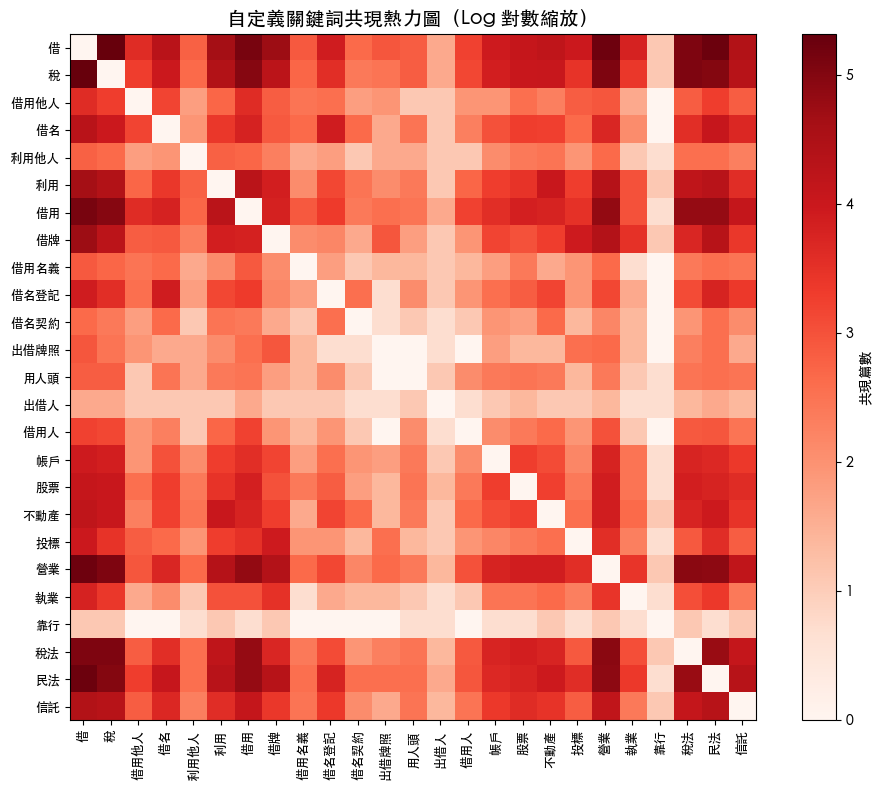

✅ 已輸出共現矩陣：/Users/iw/Documents/NTU/1141/1141_Nominee_Data/cooccurrence_from_keyword_counts.csv


In [6]:
# === 由現成關鍵詞計數矩陣繪製共現熱力圖（不再重跑 JSON 斷詞）===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
from pathlib import Path

# === 字體設定（確保中文顯示正常）===
font_path = "/System/Library/Fonts/STHeiti Light.ttc"
if Path(font_path).exists():
    font_manager.fontManager.addfont(font_path)
    plt.rcParams["font.family"] = font_manager.FontProperties(fname=font_path).get_name()
else:
    print("⚠️ 找不到中文字型，可能出現亂碼")
plt.rcParams["axes.unicode_minus"] = False

# === 載入 CSV ===
csv_path = "filtered_keywords_with_score.csv"
df = pd.read_csv(csv_path)

# 自動偵測關鍵詞欄位
keywords = [c.replace("count_", "") for c in df.columns if c.startswith("count_")]
print(f"✅ 已偵測 {len(keywords)} 個關鍵詞：{keywords}")

# === 建立共現矩陣 ===
# 任何一篇文章中若同時出現兩個詞，則共現 +1
cooccurrence = pd.DataFrame(0, index=keywords, columns=keywords, dtype=int)

for _, row in df.iterrows():
    active_words = [kw for kw in keywords if row[f"count_{kw}"] > 0]
    for i, w1 in enumerate(active_words):
        for w2 in active_words[i+1:]:
            cooccurrence.loc[w1, w2] += 1
            cooccurrence.loc[w2, w1] += 1

# === 自動修正「十字白塊」問題 ===
total_counts = cooccurrence.sum(axis=1)
median_val = total_counts.median()
high_freq_words = total_counts[total_counts > 3 * median_val].index.tolist()

if high_freq_words:
    print(f"⚠️ 偵測到過度高頻詞：{high_freq_words}，自動套用 log 對數縮放")
    data_to_plot = np.log1p(cooccurrence)
    title_suffix = "（Log 對數縮放）"
else:
    data_to_plot = cooccurrence
    title_suffix = ""

# === 熱力圖繪製 ===
plt.figure(figsize=(10, 8))
plt.imshow(data_to_plot, cmap="Reds")
plt.xticks(range(len(keywords)), keywords, rotation=90, fontsize=9)
plt.yticks(range(len(keywords)), keywords, fontsize=9)
plt.title(f"自定義關鍵詞共現熱力圖{title_suffix}", fontsize=14)
plt.colorbar(label="共現篇數")
plt.tight_layout()
plt.show()

# === 匯出結果 ===
out_path = "cooccurrence_from_keyword_counts.csv"
cooccurrence.to_csv(out_path, encoding="utf-8-sig")
print(f"✅ 已輸出共現矩陣：{Path(out_path).resolve()}")

In [10]:
import shutil
import pandas as pd
from pathlib import Path

# === 設定 ===
root_dir = Path.cwd()                   # 原始 PDF 根目錄
output_base = Path("collected")         # 匯整輸出主目錄
output_base.mkdir(parents=True, exist_ok=True)

MODE = 3                                # 1=只加流水號, 2=只原檔名, 3=兩份
NUMBER_WIDTH = 3                        # 流水號位數
CSV_PATH = Path("filtered_keywords_with_score.csv")  # 預設來源 CSV
TOP_N = 50                              # 只輸出 custom_score 降序前 N 篇，設為 None 表示全部

# === 使用者可選：手動貼清單 ===
pdf_names_text = """ """  # 若留空，則自動使用 CSV

# === 解析目標清單 ===
if pdf_names_text.strip():
    print("📄 使用手動貼上的清單。")
    target_names = [x.strip() for x in pdf_names_text.splitlines() if x.strip()]
else:
    print("📊 使用自動生成清單（依 custom_score 降序）。")
    df = pd.read_csv(CSV_PATH)
    if "paper_name" not in df.columns:
        raise ValueError("CSV 缺少欄位 'paper_name'")
    df_sorted = df.sort_values("custom_score", ascending=False)
    if TOP_N is not None:
        df_sorted = df_sorted.head(TOP_N)
        print(f"⚙️ 僅輸出前 {TOP_N} 篇（依 custom_score 排序）")
    target_names = list(df_sorted["paper_name"])

print(f"共載入 {len(target_names)} 個目標檔名。")

# === 掃描所有 PDF，建立索引 ===
print("🔍 建立索引中...")
index = {p.name: p for p in root_dir.rglob("*.pdf")}
print(f"索引完成，共 {len(index)} 個 PDF。")

# === 建立輸出資料夾 ===
numbered_dir = output_base / "with_number"
plain_dir = output_base / "no_number"
if MODE in (1, 3): numbered_dir.mkdir(parents=True, exist_ok=True)
if MODE in (2, 3): plain_dir.mkdir(parents=True, exist_ok=True)

# === 複製流程 ===
found, missing = [], []
for idx, name in enumerate(target_names, start=1):
    src = index.get(name)
    if not src:
        missing.append(name)
        print(f"❌ 找不到: {name}")
        continue
    prefix = f"{idx:0{NUMBER_WIDTH}d}_"
    try:
        if MODE in (1, 3):
            shutil.copyfile(src, numbered_dir / (prefix + name))
        if MODE in (2, 3):
            shutil.copyfile(src, plain_dir / name)
        found.append(name)
    except Exception as e:
        print(f"⚠️ 複製失敗 {name}: {e}")

# === 統計輸出 ===
print(f"\n✅ 成功複製 {len(found)} 個，❌ 找不到 {len(missing)} 個。")
if missing:
    miss = output_base / "missing_list.txt"
    miss.write_text("\n".join(missing), encoding="utf-8")
    print(f"📁 未找到清單已輸出：{miss.resolve()}")
else:
    print("所有目標檔案均成功複製。")

📊 使用自動生成清單（依 custom_score 降序）。
⚙️ 僅輸出前 50 篇（依 custom_score 排序）
共載入 50 個目標檔名。
🔍 建立索引中...
索引完成，共 293 個 PDF。

✅ 成功複製 50 個，❌ 找不到 0 個。
所有目標檔案均成功複製。
